# Assignment 3: Practical Deep Learning for Language Processing (DS405B)
submitted by Tim-Moritz Bündert (ID: 5635975) on January 27, 2022

## Setup

In [16]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# set data directory
data_dir = "/content/drive/MyDrive/University/DS405B_PDL_for_LP/Assignment_3/"

In [18]:
!pip install sentence-transformers
!pip install datasets

     |████████████████████████████████| 78 kB 3.4 MB/s 
     |████████████████████████████████| 3.4 MB 22.3 MB/s 
     |████████████████████████████████| 6.8 MB 39.0 MB/s 
     |████████████████████████████████| 1.2 MB 78.0 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
     |████████████████████████████████| 895 kB 72.4 MB/s 
     |████████████████████████████████| 596 kB 61.5 MB/s 
     |████████████████████████████████| 3.3 MB 58.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=cc59edb8e081914177ef84f2156c79289da2eed6f03f08de7b004a1571e55859
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 311 kB 4.1 MB/s 
     

In [19]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datasets import load_dataset
from collections import Counter
from tqdm import tqdm

import torch
from torch import nn
import torchtext
from torchtext.data.utils import get_tokenizer

from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader

In [20]:
device = 'cuda'

## Load datasets

In [21]:
random.seed(42) # ensure replicability

In [22]:
yahoo_dataset = load_dataset("yahoo_answers_topics", cache_dir = data_dir) # load dataset
yahoo_subset = pd.DataFrame(yahoo_dataset['test']).drop(['id', 'question_title', 'question_content'], axis=1) # keep only relevant columns
yahoo_subset = yahoo_subset[yahoo_subset['best_answer'] != ''].sample(1000, replace = False) # sample 1,000 validation examples (which contain text) from test partition
yahoo_labels = yahoo_dataset['test'].features['topic'].names # store the label names to map the numeric to the string labels in the next step
yahoo_subset['topic'] = yahoo_subset['topic'].map(lambda x : yahoo_labels[x])
yahoo_subset = yahoo_subset[['best_answer', 'topic']]

print(yahoo_subset.head())

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/867 [00:00<?, ?B/s]

Reusing dataset yahoo_answers_topics (/content/drive/MyDrive/University/DS405B_PDL_for_LP/Assignment_3/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902)


  0%|          | 0/2 [00:00<?, ?it/s]

                                             best_answer                  topic
39624  Why not try one of these body slimming and sha...                 Health
38022  I hate the term cracker.  It makes no sense wh...      Society & Culture
8716   All inks are not created equal.  From the base...  Science & Mathematics
1801   As long as their is a quality heatsink and run...   Computers & Internet
19972  Dear Young Brit, academically William and Mary...  Education & Reference


In [23]:
banking_dataset = load_dataset("banking77", cache_dir = data_dir)
banking_subset = pd.DataFrame(banking_dataset['test'])
banking_subset = banking_subset[banking_subset['text'] != ''].sample(1000, replace = False)
banking_labels = banking_dataset['test'].features['label'].names
banking_subset['label'] = banking_subset['label'].map(lambda x : banking_labels[x])

print(banking_subset.head())

Downloading:   0%|          | 0.00/2.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75k [00:00<?, ?B/s]

Using custom data configuration default
Reusing dataset banking77 (/content/drive/MyDrive/University/DS405B_PDL_for_LP/Assignment_3/banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b)


  0%|          | 0/2 [00:00<?, ?it/s]

                                                   text                     label
1569  I need your help to check my account, please! ...  declined_cash_withdrawal
1871      How long can I expect a transfer to pend for?          pending_transfer
2168  Hey I want to buy some crypto but the app does...   beneficiary_not_allowed
1337  I did a top-up, but I'm not seeing it in my wa...        topping_up_by_card
3042            Can I use your app if I am from the EU?           country_support


In [24]:
twitter_emotion_dataset = load_dataset("tweet_eval", "emotion", cache_dir = data_dir)
twitter_emotion_subset = pd.DataFrame(twitter_emotion_dataset['test'])
twitter_emotion_subset = twitter_emotion_subset[twitter_emotion_subset['text'] != ''].sample(1000, replace = False)
twitter_emotion_labels = twitter_emotion_dataset['test'].features['label'].names
twitter_emotion_subset['label'] = twitter_emotion_subset['label'].map(lambda x : twitter_emotion_labels[x])

print(twitter_emotion_subset.head())

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Reusing dataset tweet_eval (/content/drive/MyDrive/University/DS405B_PDL_for_LP/Assignment_3/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

                                                   text     label
1128  ㅤ❬ @user ❭\nㅤㅤㅤ— know what else to use to make...   sadness
1241  max @user is lit af he rly put up w my dumb as...       joy
1387  Me and @user snap streak is at 260, if that's ...       joy
24    The only upside to being deathly ill this week...  optimism
1260  Sad to hear interviews w/ Trump voters, now te...   sadness


In [25]:
twitter_sentiment_dataset = load_dataset("tweet_eval", "sentiment", cache_dir = data_dir)
twitter_sentiment_subset = pd.DataFrame(twitter_sentiment_dataset['test'])
twitter_sentiment_subset = twitter_sentiment_subset[twitter_sentiment_subset['text'] != ''].sample(1000, replace = False)
twitter_sentiment_labels = twitter_sentiment_dataset['test'].features['label'].names
twitter_sentiment_subset['label'] = twitter_sentiment_subset['label'].map(lambda x : twitter_sentiment_labels[x])

print(twitter_sentiment_subset.head())

Reusing dataset tweet_eval (/content/drive/MyDrive/University/DS405B_PDL_for_LP/Assignment_3/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

                                                    text     label
9747   If You Are In China, You Will Not Be Allowed T...   neutral
465    #tech #summary:  #tesla  #model s can be locat...  negative
3116   RT @user Literal Nazi: "I am a literal Nazi."M...  negative
10533  That nice lady will surely be missed by all of...   neutral
6288   @user I agree. Was used to good effect in that...   neutral


## Exercise 1

In [32]:
tokenizer = torchtext.data.get_tokenizer("basic_english")

def text_embedding(text):
  tokenized = tokenizer(text)
  word_embeddings = glove_6B.get_vecs_by_tokens(tokenized)
  return torch.mean(word_embeddings, dim = 0) # take element-wise mean of the word embeddings to aggregate embeddings

def evaluate_dataset_tec1(dataset, labels):
  acc = 0
  labels_emb = torch.zeros((len(labels), emb_dim_glove))
  for i, label in enumerate(labels):
    labels_emb[i,:] = text_embedding(label) # get embeddings for labels
  for j in range(dataset.shape[0]):
    text_emb = text_embedding(dataset.iloc[j,0]) # get embedding for text
    cos_sim_mat = torch.tensor([cos_sim(text_emb, labels_emb[k,:]) for k in range(len(labels))])
    pred_label = labels[torch.argmax(cos_sim_mat)] # determine label with highest cosine similarity with the text
    if pred_label == dataset.iloc[j,1]:
      acc += 1
  return acc / dataset.shape[0]

In [31]:
glove_6B = torchtext.vocab.GloVe(name='6B', dim=300, cache=data_dir)
print('Loaded {} words'.format(len(glove_6B.itos)))
emb_dim_glove = glove_6B.vectors[glove_6B.stoi['word']].shape[0]

Loaded 400000 words


In [33]:
yahoo_acc_1 = evaluate_dataset_tec1(yahoo_subset, yahoo_labels)
print(f"Accuracy on Yahoo dataset: {yahoo_acc_1}")

banking_acc_1 = evaluate_dataset_tec1(banking_subset, banking_labels)
print(f"Accuracy on Banking77 dataset: {banking_acc_1}")

twitter_emotion_acc_1 = evaluate_dataset_tec1(twitter_emotion_subset, twitter_emotion_labels)
print(f"Accuracy on Twitter Emotion dataset: {twitter_emotion_acc_1}")

twitter_sentiment_acc_1 = evaluate_dataset_tec1(twitter_sentiment_subset, twitter_sentiment_labels)
print(f"Accuracy on Twitter Sentiment dataset: {twitter_sentiment_acc_1}")

Accuracy on Yahoo dataset: 0.147
Accuracy on Banking77 dataset: 0.01
Accuracy on Twitter Emotion dataset: 0.485
Accuracy on Twitter Sentiment dataset: 0.331


## Exercise 2

In [34]:
def evaluate_dataset_tec2(dataset, labels):
  acc = 0
  labels_emb = torch.zeros((len(labels), emb_dim_sbert))
  for i, label in enumerate(labels):
    labels_emb[i,:] = model.encode(label, convert_to_tensor = True) # get embeddings for all labels
  for j in range(dataset.shape[0]):
    text_emb = model.encode(dataset.iloc[j,0], convert_to_tensor = True) # get embedding for text
    cos_sim_mat = torch.tensor([cos_sim(text_emb.to(device), labels_emb[k,:].to(device)) for k in range(len(labels))])
    pred_label = labels[torch.argmax(cos_sim_mat)] # determine label with highest cosine similarity with the text
    if pred_label == dataset.iloc[j,1]:
      acc += 1
  return acc / dataset.shape[0]

In [35]:
model = SentenceTransformer('all-mpnet-base-v2', cache_folder = data_dir)
emb_dim_sbert = model.encode('Word').shape[0]

In [36]:
yahoo_acc_2 = evaluate_dataset_tec2(yahoo_subset, yahoo_labels)
print(f"Accuracy on Yahoo dataset: {yahoo_acc_2}")

banking_acc_2 = evaluate_dataset_tec2(banking_subset, banking_labels)
print(f"Accuracy on Banking77 dataset: {banking_acc_2}")

twitter_emotion_acc_2 = evaluate_dataset_tec2(twitter_emotion_subset, twitter_emotion_labels)
print(f"Accuracy on Twitter Emotion dataset: {twitter_emotion_acc_2}")

twitter_sentiment_acc_2 = evaluate_dataset_tec2(twitter_sentiment_subset, twitter_sentiment_labels)
print(f"Accuracy on Twitter Sentiment dataset: {twitter_sentiment_acc_2}")

Accuracy on Yahoo dataset: 0.468
Accuracy on Banking77 dataset: 0.607
Accuracy on Twitter Emotion dataset: 0.682
Accuracy on Twitter Sentiment dataset: 0.373


## Exercise 3

In [39]:
def most_common_words(data, n = 1000, mode = "glove"):

  if mode == "dataset": # alternative: most common words (that are included in the Glove vocabulary) per dataset
    tokenizer = get_tokenizer("basic_english")
    counter = Counter()
    for i in tqdm(range(data.shape[0])):
      tokenized_text = tokenizer(data.iloc[i, 0])
      counter.update([word for word in tokenized_text if word in list(glove_6B.stoi)])
    most_common_words = counter.most_common(n)
    return [most_common_words[j][0] for j in range(len(most_common_words))] # only return the words, not the counts

  elif mode == "glove": # determine most common words from the GloVe vocabulary -> chosen because of computational reasons
    glove_vocab = list(glove_6B.stoi)
    return glove_vocab[:n]

  else:
    print("Please enter a correct mode.")

In [37]:
def evaluate_dataset_tec3(dataset, labels, n = 5000, lmbd = 0.1):
  words = most_common_words(dataset, n)

  # get representations of most common words by both models
  sbert_emb = model.encode(words)
  glove_emb = glove_6B.get_vecs_by_tokens(words).numpy()

  # solve for Z using Ridge Regression (SBERT X Z = GloVe)
  Z = np.linalg.solve(sbert_emb.T @ sbert_emb + lmbd * np.eye(emb_dim_sbert), sbert_emb.T @ glove_emb) # could likewise employ a library: equivalent to sklearn.linear_model.Ridge(alpha=0.1, fit_intercept = False)

  acc = 0
  labels_emb = np.zeros((len(labels), emb_dim_glove))
  for i, label in enumerate(labels):
    labels_emb[i,:] = model.encode(label, convert_to_numpy = True) @ Z # get embeddings for all labels
  for j in range(dataset.shape[0]):
    text_emb = model.encode(dataset.iloc[j,0], convert_to_numpy = True) @ Z # get embedding for text
    cos_sim_mat = np.array([cos_sim(text_emb, labels_emb[k,:]) for k in range(len(labels))])
    pred_label = labels[np.argmax(cos_sim_mat)] #  determine label with highest cosine similarity with the text
    if pred_label == dataset.iloc[j,1]:
      acc += 1
  return acc / dataset.shape[0]

In [40]:
yahoo_acc_3 = evaluate_dataset_tec3(yahoo_subset, yahoo_labels)
print(f"Accuracy on Yahoo dataset: {yahoo_acc_3}")

banking_acc_3 = evaluate_dataset_tec3(banking_subset, banking_labels)
print(f"Accuracy on Banking77 dataset: {banking_acc_3}")

twitter_emotion_acc_3 = evaluate_dataset_tec3(twitter_emotion_subset, twitter_emotion_labels)
print(f"Accuracy on Twitter Emotion dataset: {twitter_emotion_acc_3}")

twitter_sentiment_acc_3 = evaluate_dataset_tec3(twitter_sentiment_subset, twitter_sentiment_labels)
print(f"Accuracy on Twitter Sentiment dataset: {twitter_sentiment_acc_3}")

Accuracy on Yahoo dataset: 0.395
Accuracy on Banking77 dataset: 0.522
Accuracy on Twitter Emotion dataset: 0.568
Accuracy on Twitter Sentiment dataset: 0.375


## Exercise 4

In [41]:
# find the optimal number of chosen most frequent words for each dataset
range_n = [10, 100, 200, 500, 1000, 2000, 3000, 5000, 10000, 20000, 50000]
acc_datasets = []
for n in tqdm(range_n):
  acc_yahoo = evaluate_dataset_tec3(yahoo_subset, yahoo_labels, n)
  acc_banking = evaluate_dataset_tec3(banking_subset, banking_labels, n)
  acc_twitter_emotion = evaluate_dataset_tec3(twitter_emotion_subset, twitter_emotion_labels, n)
  acc_twitter_sentiment = evaluate_dataset_tec3(twitter_sentiment_subset, twitter_sentiment_labels, n)

  acc_datasets.append({'Yahoo': acc_yahoo, 'Banking77': acc_banking, 'Twitter Emotion': acc_twitter_emotion, 'Twitter Sentiment': acc_twitter_sentiment})

100%|██████████| 11/11 [14:35<00:00, 79.60s/it]


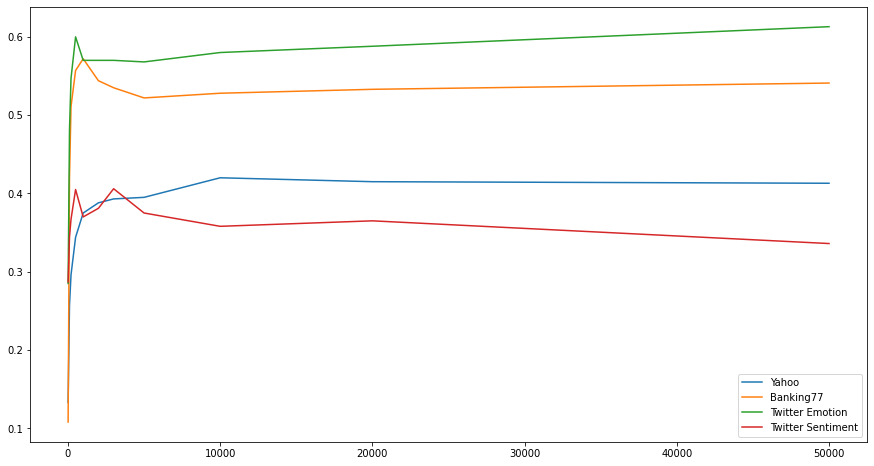

In [42]:
datasets = ["Yahoo", "Banking77", "Twitter Emotion", "Twitter Sentiment"]

plt.figure(figsize=(15, 8))
for d in datasets:
  plt.plot(range_n, [acc[d] for acc in acc_datasets], label = d)
plt.legend()
plt.show()

The graph shows that already the first few hundred most frequent words provide a major improvement in accuracy, however, with clear diminishing returns. For all datasets except the `Twitter Emotion` one, adding more words even hurts the performance. This is reasonable given the fact that the words that are later added are also less frequent and may therefore disturb the mapping matrix *Z*.

In [43]:
# store accuracies for varying n
accs_yahoo = [acc['Yahoo'] for acc in acc_datasets]
accs_banking = [acc['Banking77'] for acc in acc_datasets]
accs_twitter_emotion = [acc['Twitter Emotion'] for acc in acc_datasets]
accs_twitter_sentiment = [acc['Twitter Sentiment'] for acc in acc_datasets]

In [44]:
yahoo_acc_4 = np.max(accs_yahoo)
print(f"Accuracy on Yahoo dataset: {yahoo_acc_4} using the most {range_n[np.argmax(accs_yahoo)]} frequent words to construct Z.")

banking_acc_4 = np.max(accs_banking)
print(f"Accuracy on Banking77 dataset: {banking_acc_4} using the most {range_n[np.argmax(accs_banking)]} frequent words to construct Z.")

twitter_emotion_acc_4 = np.max(accs_twitter_emotion)
print(f"Accuracy on Twitter Emotion dataset: {twitter_emotion_acc_4} using the most {range_n[np.argmax(accs_twitter_emotion)]} frequent words to construct Z.")

twitter_sentiment_acc_4 = np.max(accs_twitter_sentiment)
print(f"Accuracy on Twitter Sentiment dataset: {twitter_sentiment_acc_4} using the most {range_n[np.argmax(accs_twitter_sentiment)]} frequent words to construct Z.")

Accuracy on Yahoo dataset: 0.42 using the most 10000 frequent words to construct Z.
Accuracy on Banking77 dataset: 0.572 using the most 1000 frequent words to construct Z.
Accuracy on Twitter Emotion dataset: 0.613 using the most 50000 frequent words to construct Z.
Accuracy on Twitter Sentiment dataset: 0.406 using the most 3000 frequent words to construct Z.


## Exercise 5

In [26]:
# Select a sample of the Yahoo training dataset because it would be unfeasible to train on the whole training dataset (1,400,000 examples) 
# Note: for the other datasets, the training dataset size is reasonably small and therefore, does not need to be adapted

random.seed(42)

n = 20000
yahoo_train_subset = pd.DataFrame(yahoo_dataset['train'])[['best_answer', 'topic']]
yahoo_train_subset = yahoo_train_subset[yahoo_train_subset['best_answer'] != ''].sample(n, replace = False)

In [27]:
# create custom PyTorch Dataset Class
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
      self.texts = texts
      self.labels = labels

    def __len__(self):
      return(len(self.texts))

    def __getitem__(self, idx):
      return (self.texts[idx], self.labels[idx])


yahoo_dataset_PT = Custom_Dataset(list(yahoo_train_subset['best_answer']), list(yahoo_train_subset['topic']))
yahoo_dataset_eval_PT = Custom_Dataset(list(yahoo_subset['best_answer']), list(yahoo_subset['topic'].map(lambda x: yahoo_labels.index(x)))) # convert string labels to numeric labels

banking_dataset_PT = Custom_Dataset(list(banking_dataset['train']['text']), list(banking_dataset['train']['label']))
banking_dataset_eval_PT = Custom_Dataset(list(banking_subset['text']), list(banking_subset['label'].map(lambda x: banking_labels.index(x))))

twitter_emotion_dataset_PT = Custom_Dataset(list(twitter_emotion_dataset['train']['text']), list(twitter_emotion_dataset['train']['label']))
twitter_emotion_dataset_eval_PT = Custom_Dataset(list(twitter_emotion_subset['text']), list(twitter_emotion_subset['label'].map(lambda x: twitter_emotion_labels.index(x))))

twitter_sentiment_dataset_PT = Custom_Dataset(list(twitter_sentiment_dataset['train']['text']), list(twitter_sentiment_dataset['train']['label']))
twitter_sentiment_dataset_eval_PT = Custom_Dataset(list(twitter_sentiment_subset['text']),list(twitter_sentiment_subset['label'].map(lambda x: twitter_sentiment_labels.index(x))))

In [28]:
# construct dataloaders

tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased") # use same tokenizer as model

def collate_batch(batch):
  input_ids = []
  attention_masks = []
  labels = []

  for text, label in batch:
      encoded_dict = tokenizer_bert.encode_plus(text,
                                                max_length = 512, # sequence length of bert-base-uncased model
                                                padding = 'max_length', # pad to max_length
                                                truncation = True, # truncate to max_length
                                                return_attention_mask = True, # attention mask (simply differentiates padding from non-padding)
                                                return_tensors = 'pt')
      
      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])
      labels.append(label)

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  return input_ids, attention_masks, labels

dataloader_yahoo = DataLoader(yahoo_dataset_PT, batch_size = 32, shuffle = True, collate_fn = collate_batch)
dataloader_yahoo_eval = DataLoader(yahoo_dataset_eval_PT, batch_size = 32, shuffle = True, collate_fn = collate_batch)

dataloader_banking = DataLoader(banking_dataset_PT, batch_size = 32, shuffle = True, collate_fn = collate_batch)
dataloader_banking_eval = DataLoader(banking_dataset_eval_PT, batch_size = 32, shuffle = True, collate_fn = collate_batch)

dataloader_twitter_emotion = DataLoader(twitter_emotion_dataset_PT, batch_size = 32, shuffle = True, collate_fn = collate_batch)
dataloader_twitter_emotion_eval = DataLoader(twitter_emotion_dataset_eval_PT, batch_size = 32, shuffle = True, collate_fn = collate_batch)

dataloader_twitter_sentiment = DataLoader(twitter_sentiment_dataset_PT, batch_size = 32, shuffle = True, collate_fn = collate_batch)
dataloader_twitter_sentiment_eval = DataLoader(twitter_sentiment_dataset_eval_PT, batch_size = 32, shuffle = True, collate_fn = collate_batch)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def finetune_BERT(eval_dataloader, eval_dataset, train_dataloader, labels, num_epochs):
  model_classifier = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = len(labels))

  # freeze most of the network
  for param in model_classifier.bert.parameters():
    param.requires_grad = False

  # re-train only the linear pooler and classifier layer
  for param in model_classifier.bert.pooler.parameters():
    param.requires_grad = True

  for param in model_classifier.classifier.parameters():
    param.requires_grad = True

  model_classifier = model_classifier.to(device)

  optimizer = torch.optim.Adam(model_classifier.parameters(), lr=1e-3)

  best_val_loss = 4 # initialize so high such that training is guaranteed to not break after first epoch
  best_val_acc = 0

  for epoch in range(num_epochs): 
    running_loss = []
    model_classifier.train()
    for batch_data in tqdm(train_dataloader):
      optimizer.zero_grad() 
      outputs = model_classifier(batch_data[0].to(device), 
                                 attention_mask = batch_data[1].to(device), 
                                 labels = batch_data[2].to(device))
      
      outputs.loss.backward() # or: loss = torch.nn.functional.cross_entropy(batch_data[2], outputs.logits) -> loss.backward()
      optimizer.step() # fine-tune the classifier
      running_loss.append(outputs.loss.item())
    
    print(f'Epoch {epoch + 1}:\nTraining Loss = {np.mean(running_loss)}')

    model_classifier.eval() # evaluate performance on validation dataset
    with torch.no_grad():
      val_loss_running = []
      val_acc = 0
      for batch_data_eval in eval_dataloader:
        outputs_eval = model_classifier(batch_data_eval[0].to(device), 
                                        attention_mask = batch_data_eval[1].to(device),
                                        labels = batch_data_eval[2].to(device))
        val_loss_running.append(outputs_eval.loss.item())
        results = outputs_eval.logits.to('cpu')
        val_acc += sum(torch.argmax(results, dim = 1) == batch_data_eval[2])
    val_loss = np.mean(val_loss_running)
    print(f'Validation Loss = {val_loss}')

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_val_acc = val_acc / len(eval_dataloader.dataset) 
      print(f'Updated best prediction on validation dataset.\n')

    else: # stop training if validation loss does not improve 
      break
        
  return best_val_acc

In [ ]:
yahoo_acc_5 = finetune_BERT(dataloader_yahoo_eval, yahoo_subset, dataloader_yahoo, yahoo_labels, num_epochs = 7)
print(f"\nAccuracy on Yahoo dataset: {yahoo_acc_5}") 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1:
Training Loss = 1.4847404788017273
Validation Loss = 1.356860987842083
Updated best prediction on validation dataset.



100%|██████████| 625/625 [06:46<00:00,  1.54it/s]


Epoch 2:
Training Loss = 1.354039406967163
Validation Loss = 1.3473698776215315
Updated best prediction on validation dataset.



100%|██████████| 625/625 [06:46<00:00,  1.54it/s]


Epoch 3:
Training Loss = 1.336968085002899
Validation Loss = 1.3107321597635746
Updated best prediction on validation dataset.



100%|██████████| 625/625 [06:46<00:00,  1.54it/s]


Epoch 4:
Training Loss = 1.316307929801941
Validation Loss = 1.3788254912942648

Accuracy on Yahoo dataset: 0.5799999833106995


In [ ]:
banking_acc_5 = finetune_BERT(dataloader_banking_eval, banking_subset, dataloader_banking, banking_labels, num_epochs = 10)
print(f"\nAccuracy on Banking77 dataset: {banking_acc_5}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1:
Training Loss = 2.7834808917853016
Validation Loss = 1.567793570458889
Updated best prediction on validation dataset.



100%|██████████| 313/313 [03:10<00:00,  1.64it/s]


Epoch 2:
Training Loss = 1.3804195877462149
Validation Loss = 1.1098272055387497
Updated best prediction on validation dataset.



100%|██████████| 313/313 [03:10<00:00,  1.64it/s]


Epoch 3:
Training Loss = 1.0932255646291251
Validation Loss = 0.9287019651383162
Updated best prediction on validation dataset.



100%|██████████| 313/313 [03:10<00:00,  1.64it/s]


Epoch 4:
Training Loss = 0.9730063241701157
Validation Loss = 0.8317057779058814
Updated best prediction on validation dataset.



100%|██████████| 313/313 [03:10<00:00,  1.64it/s]


Epoch 5:
Training Loss = 0.8655823338717318
Validation Loss = 0.8295237170532346
Updated best prediction on validation dataset.



100%|██████████| 313/313 [03:10<00:00,  1.64it/s]


Epoch 6:
Training Loss = 0.8237183567243643
Validation Loss = 0.7834686459973454
Updated best prediction on validation dataset.



100%|██████████| 313/313 [03:10<00:00,  1.64it/s]


Epoch 7:
Training Loss = 0.7950742161883333
Validation Loss = 0.8357925303280354

Accuracy on Banking77 dataset: 0.7839999794960022


In [ ]:
twitter_emotion_acc_5 = finetune_BERT(dataloader_twitter_emotion_eval, twitter_emotion_subset, dataloader_twitter_emotion, twitter_emotion_labels, num_epochs = 15)
print(f"\nAccuracy on Twitter Emotion dataset: {twitter_emotion_acc_5}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1:
Training Loss = 1.0113581892322092
Validation Loss = 0.7817496042698622
Updated best prediction on validation dataset.



100%|██████████| 102/102 [01:02<00:00,  1.63it/s]


Epoch 2:
Training Loss = 0.8288795831156712
Validation Loss = 0.7294797888025641
Updated best prediction on validation dataset.



100%|██████████| 102/102 [01:02<00:00,  1.63it/s]


Epoch 3:
Training Loss = 0.7989017691682366
Validation Loss = 0.7384208831936121

Accuracy on Twitter Emotion dataset: 0.7390000224113464


In [ ]:
twitter_sentiment_acc_5 = finetune_BERT(dataloader_twitter_sentiment_eval, twitter_sentiment_subset, dataloader_twitter_sentiment, twitter_sentiment_labels, num_epochs = 5)
print(f"\nAccuracy on Twitter Sentiment dataset: {twitter_sentiment_acc_5}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1:
Training Loss = 0.8310603252801454
Validation Loss = 0.7706574443727732
Updated best prediction on validation dataset.



100%|██████████| 1426/1426 [14:39<00:00,  1.62it/s]


Epoch 2:
Training Loss = 0.8039782028462409
Validation Loss = 0.7693254966288805
Updated best prediction on validation dataset.



100%|██████████| 1426/1426 [14:39<00:00,  1.62it/s]


Epoch 3:
Training Loss = 0.7923457765269915
Validation Loss = 0.82703054882586

Accuracy on Twitter Sentiment dataset: 0.6470000147819519


## Comparison of techniques

**Note**: because the results of Exercise 4 present an optimized version of the technique used in Exercise 3, only the results of Exercise 4 will be presented here.

In [49]:
df = pd.DataFrame(data={'Dataset': ['Yahoo', 'Banking77', 'Twitter Emotion', 'Twitter Sentiment'],
                        'GloVe (Ex. 1)':[yahoo_acc_1, banking_acc_1, twitter_emotion_acc_1, twitter_sentiment_acc_1],
                        'SBERT (Ex. 2)':[yahoo_acc_2, banking_acc_2, twitter_emotion_acc_2, twitter_sentiment_acc_2],
                        'GloVe + SBERT (Ex. 4)':[yahoo_acc_4, banking_acc_4, twitter_emotion_acc_4, twitter_sentiment_acc_4],
                        'BERT Classification (Ex. 5)':[yahoo_acc_5, banking_acc_5, twitter_emotion_acc_5, twitter_sentiment_acc_5]}).set_index('Dataset')
df.index.name = None

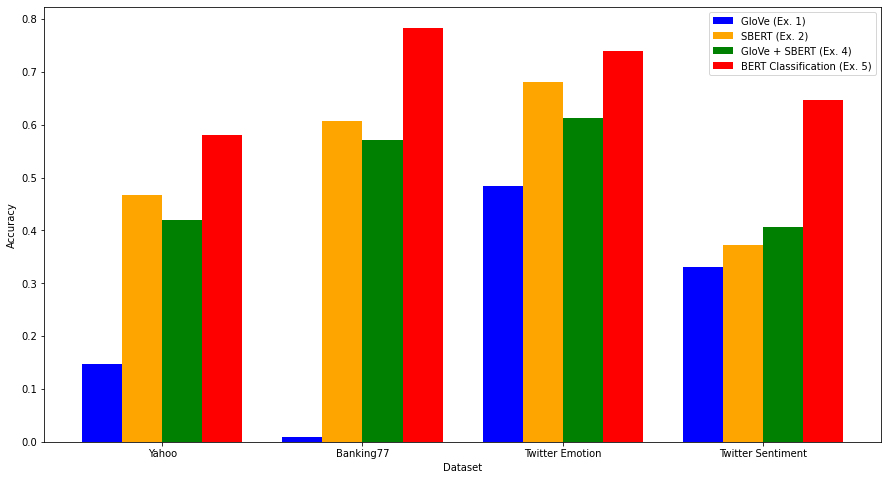

,GloVe (Ex. 1),SBERT (Ex. 2),GloVe + SBERT (Ex. 4),BERT Classification (Ex. 5)
Yahoo,0.147,0.468,0.420,0.580
Banking77,0.010,0.607,0.572,0.784
Twitter Emotion,0.485,0.682,0.613,0.739
Twitter Sentiment,0.331,0.373,0.406,0.647


In [50]:
x = np.arange(4) 
width = 0.2

plt.figure(figsize=(15, 8))

plt.bar(x-0.3, [yahoo_acc_1, banking_acc_1, twitter_emotion_acc_1, twitter_sentiment_acc_1], width, color='blue') 
plt.bar(x-0.1, [yahoo_acc_2, banking_acc_2, twitter_emotion_acc_2, twitter_sentiment_acc_2], width, color='orange') 
plt.bar(x+0.1, [yahoo_acc_4, banking_acc_4, twitter_emotion_acc_4, twitter_sentiment_acc_4], width, color='green') 
plt.bar(x+0.3, [yahoo_acc_5, banking_acc_5, twitter_emotion_acc_5, twitter_sentiment_acc_5], width, color='red') 

plt.xticks(x, ['Yahoo', 'Banking77', 'Twitter Emotion', 'Twitter Sentiment']) 
plt.xlabel("Dataset") 
plt.ylabel("Accuracy") 
plt.legend(["GloVe (Ex. 1)", "SBERT (Ex. 2)", "GloVe + SBERT (Ex. 4)", 'BERT Classification (Ex. 5)']) 
plt.show() 

display(df)

Analyzing the results, it can be seen that generally the same tendency applies to all four datasets: using the averaged `GloVe` word embeddings resulted in the worst results, for the **Yahoo** and **Banking77** dataset even by far. In contrast, using the `SBERT` embeddings resulted in (much) higher accuracies. Using both word embeddings in conjunction via the mapping matrix *Z* did in turn not improve the performance on the datasets except for the **Twitter Sentiment** one.
Finally, comparing their performance with the one of a fine-tuned supervised classifier built upon `bert-base-uncased`, the supervised model (monitoring the validation loss) is able to achieve again higher (much) accuracy.

Putting the three "*unsupervised*" classification techniques into perspective, the second (and third) method provide pretty good results which are generally not to far away from the ones of a (fine-tuned) supervised classifier but come at the benefit of not needing a training dataset/costly labels to achieve these results. Also, determining the labels with these unsupervised approaches might help against incorrectly labelled data. Hence, there might arise very intersting use cases.

## Additional Considerations

To evaluate the cost-benefit analysis of using labelled examples instead of the unsupervised approach (here, considering the `SBERT` technique [*Ex. 2*]), it can determined how many labels (examples) would be necessary for finetuning to surpass the performance of the unsupervised method.

For that purpose, we will consider the **Yahoo** dataset and compute the accuracy on the validation dataset after the finetuning of every 10 batches (10*32 = 320 examples) [using one epoch].

In [29]:
model_classifier = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = len(yahoo_labels))

for param in model_classifier.bert.parameters():
  param.requires_grad = False

# re-train only the linear pooler and classifier layer
for param in model_classifier.bert.pooler.parameters():
  param.requires_grad = True

for param in model_classifier.classifier.parameters():
  param.requires_grad = True

model_classifier = model_classifier.to(device)

optimizer = torch.optim.Adam(model_classifier.parameters(), lr=1e-3)

val_accs = []
n_examples = []

for n, batch_data in enumerate(tqdm(dataloader_yahoo)):
  model_classifier.train()
  optimizer.zero_grad() 
  outputs = model_classifier(batch_data[0].to(device), 
                             attention_mask = batch_data[1].to(device), 
                             labels = batch_data[2].to(device))
  
  outputs.loss.backward()
  optimizer.step() 

  if n % 10 == 0: # evaluate validation accuracy every 10 batches
    val_acc = 0
    model_classifier.eval()
    with torch.no_grad():
      for batch_data_eval in dataloader_yahoo_eval:
        outputs_eval = model_classifier(batch_data_eval[0].to(device), 
                                        attention_mask = batch_data_eval[1].to(device),
                                        labels = batch_data_eval[2].to(device))
        results = outputs_eval.logits.to('cpu')
        val_acc += sum(torch.argmax(results, dim = 1) == batch_data_eval[2])
    val_accs.append(val_acc / len(dataloader_yahoo_eval.dataset))
    n_examples.append((n+1)*32)
print(val_accs)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[tensor(0.0980), tensor(0.2920), tensor(0.2940), tensor(0.4130), tensor(0.4710), tensor(0.4840), tensor(0.4830), tensor(0.5240), tensor(0.5150), tensor(0.5250), tensor(0.5400), tensor(0.5210), tensor(0.5530), tensor(0.5400), tensor(0.5440), tensor(0.5400), tensor(0.5660), tensor(0.5410), tensor(0.5300), tensor(0.5500), tensor(0.5610), tensor(0.5640), tensor(0.5660), tensor(0.5590), tensor(0.5620), tensor(0.5370), tensor(0.5620), tensor(0.5720), tensor(0.5660), tensor(0.5770), tensor(0.5430), tensor(0.5540), tensor(0.5600), tensor(0.5730), tensor(0.5320), tensor(0.5600), tensor(0.5600), tensor(0.5620), tensor(0.5270), tensor(0.5590), tensor(0.5770), tensor(0.5610), tensor(0.5770), tensor(0.5590), tensor(0.5330), tensor(0.5530), tensor(0.5630), tensor(0.5730), tensor(0.5690), tensor(0.5760), tensor(0.5690), tensor(0.5630), tensor(0.5500), tensor(0.5670), tensor(0.5810), tensor(0.5730), tensor(0.5800), tensor(0.5470), tensor(0.5350), tensor(0.5530), tensor(0.5500), tensor(0.5690), tensor(

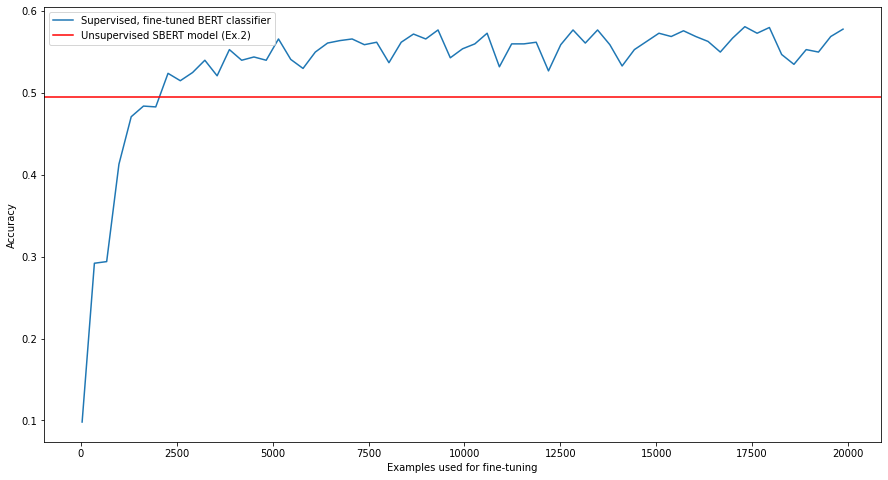

In [30]:
plt.figure(figsize=(15, 8))
plt.plot(n_examples, val_accs, label = 'Supervised, fine-tuned BERT classifier')
plt.axhline(y=yahoo_acc_2, label = 'Unsupervised SBERT model (Ex.2)', color = 'r')
plt.xlabel("Examples used for fine-tuning")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Hence, it can be seen that the benefit of the supervised classifier only arises after fine-tuning it with roughly 2,000 labelled examples. Below this threshold, the unsupervised `SBERT` model performs better which highlights its advantage, in particular, if few labelled data is available / labelled data is very costly.